# **Data-format**

In [ ]:
# dataset/
#     images/
#         img1.jpg
#         img2.jpg
#         ...
#     masked/
#         img1.jpg
#         img2.jpg
#         ...

# **Unzip dataset**

In [1]:
!unzip /content/DLINKNET_DATA.zip

Archive:  /content/DLINKNET_DATA.zip
   creating: DLINKNET_DATA/
   creating: DLINKNET_DATA/masked/
  inflating: DLINKNET_DATA/masked/Abyssinian_172.png  
  inflating: DLINKNET_DATA/masked/Abyssinian_174.png  
  inflating: DLINKNET_DATA/masked/Abyssinian_173.png  
  inflating: DLINKNET_DATA/masked/Abyssinian_175.png  
  inflating: DLINKNET_DATA/masked/Abyssinian_176.png  
   creating: DLINKNET_DATA/images/
  inflating: DLINKNET_DATA/images/Abyssinian_174.png  
  inflating: DLINKNET_DATA/images/Abyssinian_173.png  
  inflating: DLINKNET_DATA/images/Abyssinian_172.png  
  inflating: DLINKNET_DATA/images/Abyssinian_176.png  
  inflating: DLINKNET_DATA/images/Abyssinian_175.png  


# **Required params**

In [2]:
# Use Google Colab
use_google_colab = True
# Process the training dataset
training_data_processing = True
# Train the model
model_training = True
# Validation the model
model_validation = False
# Load the model from your Google Drive or local file system
model_loading = False

In [4]:
if use_google_colab:
    from google.colab import drive
    from google.colab import files
    # Mount your Google Drive on your runtime
    # drive.mount('/content/gdrive')

# **Import libraries**

In [62]:
%matplotlib inline
import numpy as np
import torch
from torch import nn
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from skimage.transform import resize
import scipy
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import cv2

# **Path (for training n infer)**

In [6]:
if use_google_colab:
    path_training = '/content/DLINKNET_DATA'
    path_testing = '/content/DLINKNET_DATA/images'
    path_data = '/content/store_data_n_model/data/'
    path_model = '/content/store_data_n_model/models/'
else:
    path_training = 'training/'
    path_testing = 'test_set_images/'
    path_data = 'data/'
    path_model = 'models/'

# **Get Device for Training**

In [7]:
# Determine if your system supports CUDA
cuda_available = torch.cuda.is_available()
if cuda_available:
    print('CUDA is available. Utilize GPUs for computation')
    device = torch.device("cuda")
else:
    print('CUDA is not available. Utilize CPUs for computation.')
    device = torch.device("cpu")

CUDA is available. Utilize GPUs for computation


In [8]:
# Get the GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Mon Aug 19 10:55:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **Define the Neural Network**

In [9]:
"""
LinkNetB7.py - Define the neural network for LinkNetB7.
"""

class decoder_block(nn.Module):
    # Instantiate all the modules
    def __init__(self, in_channels, out_channels, stride=2, output_padding=1):
        super(decoder_block,self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 4, kernel_size=1),
            nn.BatchNorm2d(in_channels // 4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=3,
                               stride=stride, padding=1, output_padding=output_padding),
            nn.BatchNorm2d(in_channels // 4),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels // 4, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    # Define the block structure
    def forward(self, x):
        """
        decoder_block's forward function.
        Args:
            x (tensor): input tensor
        Returns:
            x (tensor): the output of this block after processing
        """
        x = self.block(x)
        return x


class LinkNetB7(nn.Module):
    # Instantiate all the modules
    def __init__(self):
        super(LinkNetB7, self).__init__()
        # Construct a EfficientNetB7 architecture from https://arxiv.org/abs/1905.11946
        # Return a model pre-trained on ImageNet
        efficientnet = models.efficientnet_b7(pretrained=True)

        # Input Block
        self.input_block = nn.Sequential(*(list(efficientnet.children())[0][0]))

        # Encoder Blocks
        self.encoder1 = nn.Sequential(*(list(efficientnet.children())[0][1]))
        self.encoder2 = nn.Sequential(*(list(efficientnet.children())[0][2]))
        self.encoder3 = nn.Sequential(*(list(efficientnet.children())[0][3]))
        self.encoder4 = nn.Sequential(*(list(efficientnet.children())[0][4]))
        self.encoder5 = nn.Sequential(*(list(efficientnet.children())[0][5]))
        self.encoder6 = nn.Sequential(*(list(efficientnet.children())[0][6]))
        self.encoder7 = nn.Sequential(*(list(efficientnet.children())[0][7]))

        # Decoder Blocks
        self.decoder7 = decoder_block(640, 384, stride=1, output_padding=0)
        self.decoder6 = decoder_block(384, 224, stride=2, output_padding=1)
        self.decoder5 = decoder_block(224, 160, stride=1, output_padding=0)
        self.decoder4 = decoder_block(160, 80, stride=2, output_padding=1)
        self.decoder3 = decoder_block(80, 48, stride=2, output_padding=1)
        self.decoder2 = decoder_block(48, 32, stride=2, output_padding=1)
        self.decoder1 = decoder_block(32, 64, stride=2, output_padding=1)

        # Output Block
        self.output_block = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=2, padding=1),
            nn.Sigmoid()
        )

    # Define the network structure
    def forward(self, x):
        """
        LinkNetB7's forward function.
        Args:
            x (tensor): input tensor
        Returns:
            o1 (tensor): the output of this model after processing
        """
        # Input
        i1 = self.input_block(x)

        # Encoding
        e1 = self.encoder1(i1)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)
        e6 = self.encoder6(e5)
        e7 = self.encoder7(e6)

        # Decoding
        d7 = self.decoder7(e7) + e6
        d6 = self.decoder6(d7) + e5
        d5 = self.decoder5(d6) + e4
        d4 = self.decoder4(d5) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        # Output
        o1 = self.output_block(d1)

        return o1

In [42]:
import torch
import torch.nn as nn
import torchvision.models as models

class decoder_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2, output_padding=1):
        super(decoder_block, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 4, kernel_size=1),
            nn.BatchNorm2d(in_channels // 4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=3,
                               stride=stride, padding=1, output_padding=output_padding),
            nn.BatchNorm2d(in_channels // 4),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels // 4, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        """
        decoder_block's forward function.
        Args:
            x (tensor): input tensor
        Returns:
            x (tensor): the output of this block after processing
        """
        x = self.block(x)
        return x

class LinkNetB7(nn.Module):
    def __init__(self):
        super(LinkNetB7, self).__init__()
        # Load pre-trained EfficientNetB7
        efficientnet = models.efficientnet_b7(pretrained=True)

        # Input Block
        self.input_block = nn.Sequential(*list(efficientnet.children())[0][:1])

        # Encoder Blocks
        self.encoder1 = nn.Sequential(*list(efficientnet.children())[0][1])
        self.encoder2 = nn.Sequential(*list(efficientnet.children())[0][2])
        self.encoder3 = nn.Sequential(*list(efficientnet.children())[0][3])
        self.encoder4 = nn.Sequential(*list(efficientnet.children())[0][4])
        self.encoder5 = nn.Sequential(*list(efficientnet.children())[0][5])
        self.encoder6 = nn.Sequential(*list(efficientnet.children())[0][6])
        self.encoder7 = nn.Sequential(*list(efficientnet.children())[0][7])

        # Decoder Blocks
        self.decoder7 = decoder_block(640, 384, stride=1, output_padding=0)
        self.decoder6 = decoder_block(384, 224, stride=2, output_padding=1)
        self.decoder5 = decoder_block(224, 160, stride=1, output_padding=0)
        self.decoder4 = decoder_block(160, 80, stride=2, output_padding=1)
        self.decoder3 = decoder_block(80, 48, stride=2, output_padding=1)
        self.decoder2 = decoder_block(48, 32, stride=2, output_padding=1)
        self.decoder1 = decoder_block(32, 64, stride=2, output_padding=1)

        # Output Block
        self.output_block = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        LinkNetB7's forward function.
        Args:
            x (tensor): input tensor
        Returns:
            o1 (tensor): the output of this model after processing
        """
        # Input
        i1 = self.input_block(x)

        # Encoding
        e1 = self.encoder1(i1)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)
        e6 = self.encoder6(e5)
        e7 = self.encoder7(e6)

        # Decoding
        d7 = self.decoder7(e7) + e6
        d6 = self.decoder6(d7) + e5
        d5 = self.decoder5(d6) + e4
        d4 = self.decoder4(d5) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        # Output
        o1 = self.output_block(d1)

        return o1


# **Create an Instance of the Neural Network**

In [43]:
model = LinkNetB7()
if cuda_available:
    # Move the model to GPU
    model.cuda()
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


LinkNetB7(
  (input_block): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
  )
  (encoder1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0

# **Load and Process the Training Dataset**

In [44]:
# The resolution of resized training images and the corresponding masks
training_resize = 384
# The number of resized training pairs used for data augmentation
training_number = 1
# The resolution of resized testing images
testing_resize = int(608 * training_resize / 500)
if testing_resize % 2 == 1:
    testing_resize += 1

In [45]:
import numpy as np
import os
from PIL import Image
from skimage.transform import resize
import scipy.ndimage
from tqdm import tqdm

def training_data_loading(path_training='linknet/', training_resize=384, training_number=100):
    """
    Load and generate the resized training dataset and validation dataset.

    Args:
        path_training (str): the location in your Google Drive or local file system
        training_resize (int): the resolution of resized training images and their corresponding masks (training pairs)
        training_number (int): the number of resized training pairs used for data augmentation

    Returns:
        images_training, labels_training (numpy): the resized training dataset
        images_validation, labels_validation (numpy): the resized validation dataset
    """
    # Determine the number of images available in the dataset
    image_files = sorted([f for f in os.listdir(os.path.join(path_training, 'images')) if f.endswith('.png')])
    num_images = len(image_files)
    print(image_files)

    # Initialize arrays for storing images and labels
    images_loading = np.empty(shape=(num_images, 3, training_resize, training_resize))
    labels_loading = np.empty(shape=(num_images, 1, training_resize, training_resize))

    for index, filename in enumerate(image_files):
        img_path = os.path.join(path_training, 'images', filename)
        mask_path = os.path.join(path_training, 'masked', filename)

        # Load image and label
        image = np.array(Image.open(img_path)).astype(float) / 255
        label = np.array(Image.open(mask_path)).astype(float) / 255

        # Resize images and labels
        image = resize(image, (training_resize, training_resize, 3), mode='reflect')
        label = resize(label, (training_resize, training_resize, 1), mode='reflect')

        # Transpose to (C, H, W) format
        image = np.transpose(image, (2, 0, 1))
        label = np.transpose(label, (2, 0, 1))

        images_loading[index] = image
        labels_loading[index] = label

    # Permute the resized dataset randomly
    permuted_sequence = np.random.permutation(num_images)
    images_loading = images_loading[permuted_sequence]
    labels_loading = labels_loading[permuted_sequence]

    # Generate the training and validation datasets
    images_training = images_loading[:training_number]
    labels_training = labels_loading[:training_number]
    images_validation = images_loading[training_number:]
    labels_validation = labels_loading[training_number:]

    return images_training, labels_training, images_validation, labels_validation

def training_data_augmentation(images_training, labels_training, rotations, flips, shifts, training_resize=384):
    """
    Generate the augmented training dataset.

    Args:
        images_training, labels_training (numpy): the resized training dataset
        rotations (list): the parameters for rotating resized training images and their corresponding masks
        flips (list): the parameters for flipping rotated training pairs
        shifts (list): the parameters for shifting flipped training pairs
        training_resize (int): the resolution of resized training pairs

    Returns:
        images_augmented, labels_augmented (numpy): the augmented training dataset
    """
    num_rota = len(rotations)
    num_flip = len(flips)
    num_shft = len(shifts)

    num_training = images_training.shape[0]
    num_augmented = num_training * num_rota * num_flip * num_shft
    images_augmented = np.empty(shape=(num_augmented, 3, training_resize, training_resize))
    labels_augmented = np.empty(shape=(num_augmented, 1, training_resize, training_resize))

    counter = 0
    for index in tqdm(range(num_training)):
        image = np.transpose(images_training[index], (1, 2, 0))
        label = np.transpose(labels_training[index], (1, 2, 0))
        for rota in rotations:
            for flip in flips:
                for shft in shifts:
                    # Rotate a resized training pair
                    image_rota = scipy.ndimage.rotate(image, rota, reshape=False, mode='reflect')
                    label_rota = scipy.ndimage.rotate(label, rota, reshape=False, mode='reflect')

                    # Flip the rotated training pair
                    if flip == 'original':
                        image_flip = image_rota
                        label_flip = label_rota
                    else:
                        image_flip = flip(image_rota)
                        label_flip = flip(label_rota)

                    # Shift the flipped training pair
                    shft_H = np.random.uniform(low=shft[0], high=shft[1], size=1)[0]
                    shft_W = np.random.uniform(low=shft[0], high=shft[1], size=1)[0]
                    image_shft = scipy.ndimage.shift(image_flip, (shft_H, shft_W, 0), mode='reflect')
                    label_shft = scipy.ndimage.shift(label_flip, (shft_H, shft_W, 0), mode='reflect')

                    images_augmented[counter] = np.clip(np.transpose(image_shft, (2, 0, 1)), 0, 1)
                    labels_augmented[counter] = np.transpose(label_shft, (2, 0, 1)) > 0.3
                    counter += 1

    # Permute the augmented training dataset randomly
    permuted_sequence = np.random.permutation(num_augmented)
    images_augmented = images_augmented[permuted_sequence]
    labels_augmented = labels_augmented[permuted_sequence]

    return images_augmented, labels_augmented


In [46]:
if training_data_processing:
    # Load and generate the resized training dataset and validation dataset
    images_training, labels_training, images_validation, labels_validation = training_data_loading(path_training,
                                                                                                   training_resize,
                                                                                                   training_number)
    # Generate the augmented training dataset
    rotations = [0, 45, 90, 135] # the rotation angle

    flips = ['original', np.flipud, np.fliplr] # 'original', np.flipud, np.fliplr

    shifts = [(-16, 16)]

    images_augmented, labels_augmented = training_data_augmentation(images_training,
                                                                    labels_training,
                                                                    rotations,
                                                                    flips,
                                                                    shifts,
                                                                    training_resize)
    # Save the augmented training dataset and resized validation dataset
    # to your Google Drive or local file system
    np.save(f'{path_data}images_training', images_augmented)
    np.save(f'{path_data}labels_training', labels_augmented)
    np.save(f'{path_data}images_validation', images_validation)
    np.save(f'{path_data}labels_validation', labels_validation)
elif not model_loading:
    # Load the augmented training dataset and resized validation dataset
    # from your Google Drive or local file system
    images_augmented = np.load(f'{path_data}images_training.npy')
    labels_augmented = np.load(f'{path_data}labels_training.npy')
    images_validation = np.load(f'{path_data}images_validation.npy')
    labels_validation = np.load(f'{path_data}labels_validation.npy')

['Abyssinian_172.png', 'Abyssinian_173.png', 'Abyssinian_174.png', 'Abyssinian_175.png', 'Abyssinian_176.png']


100%|██████████| 1/1 [00:05<00:00,  5.42s/it]


# **Train the Instance of the Neural Network**

In [20]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.bce_loss = nn.BCELoss()

    def forward(self, outputs, targets, smooth=0):
        """
        DiceBCELoss - Compute the Dice-BCE Loss.
        Args:
            outputs (tensor): output tensor
            targets (tensor): target tensor
        Returns:
            dice_BCE_loss (tensor): the Dice-BCE Loss
        """
        # Flatten output and target tensors
        outputs = outputs.view(-1)
        targets = targets.view(-1)

        # Compute the dice Loss
        intersection = (outputs * targets).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (outputs.sum() + targets.sum() + smooth)

        # Compute the standard binary cross-entropy (BCE) loss
        BCE_loss = self.bce_loss(outputs, targets)

        dice_BCE_loss = dice_loss + BCE_loss

        return dice_BCE_loss


class BCEIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(BCEIoULoss, self).__init__()
        self.bce_loss = nn.BCELoss()

    def forward(self, outputs, targets, beta=0.6, alpha=0.25, gamma=3, smooth=0):
        """
        BCEIoULoss - Compute the BCEIoULoss Loss.
        Args:
            outputs (tensor): output tensor
            targets (tensor): target tensor
        Returns:
            BCE_IoU_loss (tensor): the BCE-IoU Loss
        """
        # Flatten output and target tensors
        outputs = outputs.view(-1)
        targets = targets.view(-1)

        # Compute the intersection-over-union (IoU) loss
        intersection = (outputs * targets).sum()
        total = (outputs + targets).sum()
        union = total - intersection
        IoU_loss = 1 - (intersection + smooth) / (union + smooth)

        # Compute the modified BCE loss
        BCE_loss = self.bce_loss(outputs, targets)
        BCE_exp = torch.exp(-BCE_loss)
        modified_BCE_loss = alpha * (1 - BCE_exp) ** gamma * BCE_loss

        BCE_IoU_loss = beta * modified_BCE_loss + (1 - beta) * IoU_loss

        return BCE_IoU_loss

In [47]:
import torch
import torch.nn as nn

class BCEIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(BCEIoULoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, outputs, targets, beta=0.6, alpha=0.25, gamma=3, smooth=1e-6):
        """
        BCEIoULoss - Compute the BCEIoULoss Loss.
        Args:
            outputs (tensor): output tensor (logits)
            targets (tensor): target tensor
        Returns:
            BCE_IoU_loss (tensor): the BCE-IoU Loss
        """
        # Flatten output and target tensors
        outputs = outputs.view(-1)
        targets = targets.view(-1)

        # Compute the intersection-over-union (IoU) loss
        intersection = (outputs * targets).sum()
        total = (outputs + targets).sum()
        union = total - intersection
        IoU_loss = 1 - (intersection + smooth) / (union + smooth)

        # Compute the modified BCE loss
        BCE_loss = self.bce_loss(outputs, targets)
        BCE_exp = torch.exp(-BCE_loss)
        modified_BCE_loss = alpha * (1 - BCE_exp) ** gamma * BCE_loss

        BCE_IoU_loss = beta * modified_BCE_loss + (1 - beta) * IoU_loss

        return BCE_IoU_loss


In [49]:
print(len(images_augmented),len(images_validation))

12 4


In [66]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

def train(model,
          images_training,
          labels_training,
          images_validation,
          labels_validation,
          loss_func,
          batch_size=1,  # Start with a very small batch size
          learning_rate=1e-3,
          epochs=80,
          model_validation=False,
          cuda_available=True,
          path_model='models/',
          gradient_accumulation_steps=1):
    """
    train - Train the instance of the neural network.
    Args:
        model (torch): the instance of the neural network
        images_training, labels_training (numpy): the augmented training dataset
        images_validation, labels_validation (numpy): the resized validation dataset
        loss_func (class): the loss function
        batch_size (int): the number of samples per batch to load (default: 1)
        learning_rate (float): the learning rate (default: 1e-3)
        epochs (int): the learning epochs (default: 80)
        model_validation (bool): the flag indicating whether or not to implement validation (default: False)
        cuda_available (bool): the flag indicating whether CUDA is available (default: True)
        path_model (str): the path where the model will be saved (default: 'models/')
        gradient_accumulation_steps (int): number of steps to accumulate gradients (default: 1)
    """
    # Convert numpy arrays to torch tensors
    images_training = torch.tensor(images_training, dtype=torch.float32)
    labels_training = torch.tensor(labels_training, dtype=torch.float32)
    training_set = TensorDataset(images_training, labels_training)
    training_generator = DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

    if model_validation and len(images_validation) > 0:
        images_validation = torch.tensor(images_validation, dtype=torch.float32)
        labels_validation = torch.tensor(labels_validation, dtype=torch.float32)
        validation_set = TensorDataset(images_validation, labels_validation)
        validation_generator = DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
    scaler = GradScaler()

    for epoch in tqdm(range(epochs)):
        print(f'\n---------Training for Epoch {epoch + 1} starting:---------')
        model.train()
        loss_training = 0
        optimizer.zero_grad()

        for index, (inputs, labels) in enumerate(training_generator):
            if cuda_available:
                try:
                    inputs, labels = inputs.cuda(non_blocking=True), labels.cuda(non_blocking=True)
                except RuntimeError as e:
                    print(f"RuntimeError during tensor transfer: {e}")
                    torch.cuda.empty_cache()
                    continue

            try:
                with autocast():
                    outputs = model(inputs)
                    loss = loss_func(outputs, labels)
                    scaler.scale(loss).backward()

                if (index + 1) % gradient_accumulation_steps == 0 or (index + 1) == len(training_generator):
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()

                loss_training += loss.item()
                if index % 20 == 0:
                    print(f'→ Running_loss for Batch {index + 1}: {loss.item()}')

            except RuntimeError as e:
                print(f"RuntimeError during forward/backward pass: {e}")
                torch.cuda.empty_cache()

        print(f'\033[1mTraining loss for Epoch {epoch + 1}: {loss_training}\033[0m\n')

        if model_validation and len(images_validation) > 0:
            print(f'--------Validation for Epoch {epoch + 1} starting:--------')
            model.eval()
            loss_validation = 0
            with torch.no_grad():
                for index, (inputs, labels) in enumerate(validation_generator):
                    if cuda_available:
                        try:
                            inputs, labels = inputs.cuda(non_blocking=True), labels.cuda(non_blocking=True)
                        except RuntimeError as e:
                            print(f"RuntimeError during tensor transfer: {e}")
                            torch.cuda.empty_cache()
                            continue

                    try:
                        outputs = model(inputs)
                        loss_validation += loss_func(outputs, labels).item()
                    except RuntimeError as e:
                        print(f"RuntimeError during forward pass: {e}")
                        torch.cuda.empty_cache()

            print(f'\033[1mValidation loss for Epoch {epoch + 1}: {loss_validation}\033[0m\n')

        scheduler.step()
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_func,
                }, path_model + 'model.model')

        # Print memory usage
        if cuda_available:
            print(f"CUDA Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
            print(f"CUDA Memory Cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
            torch.cuda.empty_cache()



In [67]:
# Example usage (adjust arguments as necessary)
if model_training:
    train(model,
          images_training,
          labels_training,
          images_validation,
          labels_validation,
          loss_func=BCEIoULoss(),  # or other loss functions
          batch_size=2,  # Test with the smallest batch size
          learning_rate=1e-3,
          epochs=3,
          model_validation=model_validation,
          cuda_available=cuda_available,
          path_model=path_model,
          gradient_accumulation_steps=4)  # Adjust as needed


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/3 [00:00<?, ?it/s]


---------Training for Epoch 1 starting:---------
→ Running_loss for Batch 1: 0.20706382393836975
Training loss for Epoch 1: 0.20706382393836975

CUDA Memory Allocated: 736.85 MB
CUDA Memory Cached: 8442.00 MB


 33%|███▎      | 1/3 [00:10<00:20, 10.02s/it]


---------Training for Epoch 2 starting:---------
→ Running_loss for Batch 1: 0.2046222686767578
Training loss for Epoch 2: 0.2046222686767578



 67%|██████▋   | 2/3 [00:16<00:07,  7.67s/it]

CUDA Memory Allocated: 736.85 MB
CUDA Memory Cached: 1870.00 MB

---------Training for Epoch 3 starting:---------
→ Running_loss for Batch 1: 0.1871936023235321
Training loss for Epoch 3: 0.1871936023235321



100%|██████████| 3/3 [00:25<00:00,  8.41s/it]

CUDA Memory Allocated: 736.85 MB
CUDA Memory Cached: 1870.00 MB


In [57]:
if model_loading:
    # Load the model from your Google Drive or local file system
    checkpoint = torch.load(path_model + 'model.model')
    model.load_state_dict(checkpoint['model_state_dict'])

# **Process the Testing Dataset and Create the Submission File**

In [60]:
def testing_patch_extracting(input, trar=384, tesr=584):
    """
    testing_patch_extracting - Divide each resized testing image into four patches, one at each corner.
    Args:
        input (numpy) - the resized testing image
        trar (int) - the resolution of resized training images and the corresponding masks
        tesr (int) - the resolution of resized testing images
    Returns:
        input_patches (numpy) - the four patches
    """
    if tesr / 2 > trar:
        raise AssertionError("training_resize is too small.")

    input_patches = np.empty(shape=(4, input.shape[2], trar, trar))
    input_patches[0] = np.transpose(input[0:0+trar, 0:0+trar, :], (2, 0, 1))
    input_patches[1] = np.transpose(input[0:0+trar, tesr-trar:tesr, :], (2, 0, 1))
    input_patches[2] = np.transpose(input[tesr-trar:tesr, 0:0+trar, :], (2, 0, 1))
    input_patches[3] = np.transpose(input[tesr-trar:tesr, tesr-trar:tesr, :], (2, 0, 1))

    return input_patches


def testing_patch_assembling(output_patches, trar=384, tesr=584):
    """
    testing_patch_assembling - Merge the four masks into one resized mask.
    Args:
        output_patches (numpy) - the masks of the four patches
        trar (int) - the resolution of resized training images and the corresponding masks
        tesr (int) - the resolution of resized testing images
    Returns:
        output (numpy) - the resized mask
    """
    # The extracting length
    eL = int(tesr / 2)

    output = np.empty(shape=(output_patches.shape[1], tesr, tesr))
    output[:, 0:eL, 0:eL] = output_patches[0, :, 0:eL, 0:eL]
    output[:, 0:eL, tesr-eL:tesr] = output_patches[1, :, 0:eL, trar-eL:trar]
    output[:, tesr-eL:tesr, 0:eL] = output_patches[2, :, trar-eL:trar, 0:eL]
    output[:, tesr-eL:tesr, tesr-eL:tesr] = output_patches[3, :, trar-eL:trar, trar-eL:trar]

    return output

def mask_to_submission(output, index):
    """
    mask_to_submission - Convert the mask of each testing image into the submission format.
    Args:
        output (numpy) - the mask of the testing image
        index (int) - the index of the testing image
    Returns:
        mask_submission (list) - the submission format of the mask
    """
    mask_submission = []
    for i in range(0, output.shape[0], 16):
        for j in range(0, output.shape[1], 16):
            prediction = 0
            patch = output[j:j+16, i:i+16]
            if np.mean(patch > 0.2) > 0.25:
                prediction = 1
            mask_submission.append(["{:03d}_{}_{}".format(index, i, j), prediction])
    return mask_submission


def submission_creating(model, path_testing='test_set_images/', training_resize=384, testing_resize=584, cuda_available=True):
    """
    submission_creating - Load and generate the resized training dataset and validation dataset.
    Args:
        model (torch): the instance of the neural network
        path_testing (str): the location in your Google Drive or local file system
        training_resize (int): the resolution of resized training images and their corresponding masks (training pairs) (default: 384)
        testing_resize (int): the resolution of resized testing images (default: 584)
        cuda_available (bool): the flag indicating whether CUDA is available (default: True)
    Returns:
        submission (numpy): the final submission file
    """
    submit_outputs = []
    for index,filename in enumerate(os.listdir(path_testing)):
        if filename.lower().endswith('png'):
            image_path = os.path.join(path_testing, filename)

            # Load a testing image using OpenCV
            input = cv2.imread(image_path)
            input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB).astype('float32') / 255

            # Resize the testing image
            input = resize(input, (testing_resize, testing_resize))

        # Divide the resized testing image into four patches, one at each corner.
        input_patches = testing_patch_extracting(input, training_resize, testing_resize)
        input_patches = torch.from_numpy(input_patches).float()

        # Predict the mask of the four patches
        if cuda_available:
            output_patches = model(input_patches.cuda()).detach().cpu().numpy()
        else:
            output_patches = model(input_patches).detach().numpy()

        # Merge the four masks into one resized mask
        output = testing_patch_assembling(output_patches, training_resize, testing_resize)[0, :, :]

        # Restore the resized mask to the original resolution
        output = resize(output, (608, 608))

        # Convert the mask of the testing image into the submission format
        submit_output = mask_to_submission(output, index)

        submit_outputs.append(submit_output)

    submission = np.concatenate(submit_outputs, axis=0)
    submission = np.concatenate(([['id', 'prediction']], submission), axis=0)

    return submission

In [63]:
submission = submission_creating(model,
                                 path_testing,
                                 training_resize,
                                 testing_resize,
                                 cuda_available)

np.savetxt("submit.csv", submission, delimiter=",", fmt = '%s')
if use_google_colab:
  print("done")
    # files.download('submit.csv')

done


infer code

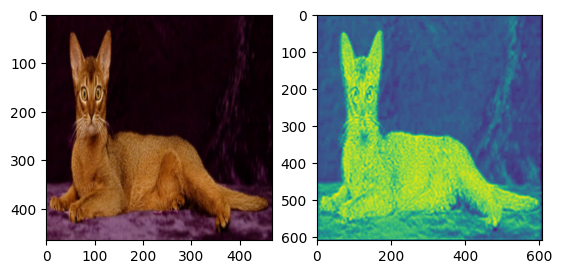

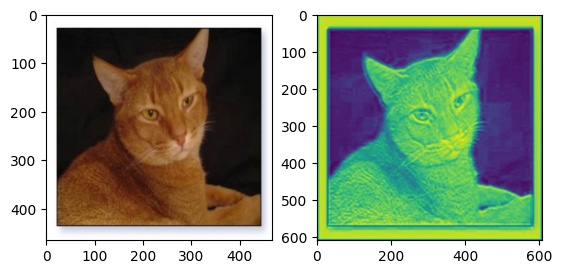

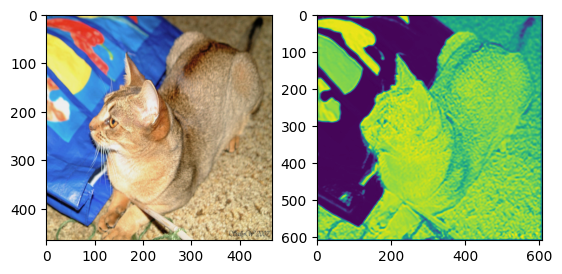

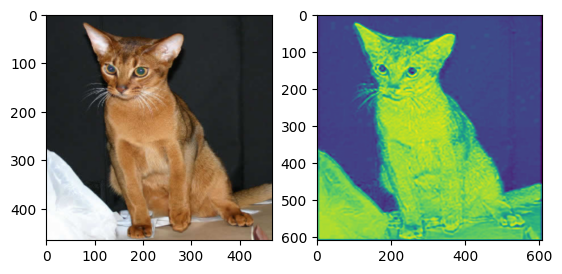

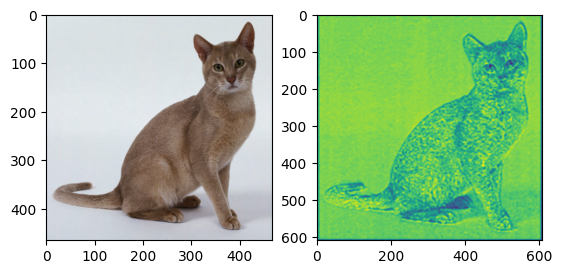

In [64]:
model.eval()
for filename in os.listdir(path_testing):
  # print(filename[-3:])
  if filename[-3:] == 'png':
    image_path = os.path.join(path_testing,filename)

    # Load a testing image
    input = np.array(Image.open(image_path)).astype('float32') / 255

    # Resize the testing image
    input = resize(input, (testing_resize, testing_resize))

    # Divide the resized testing image into four patches, one at each corner.
    input_patches = testing_patch_extracting(input, training_resize, testing_resize)
    input_patches = torch.from_numpy(input_patches).float()

    # Predict the mask of the four patches
    if cuda_available:
        output_patches = model(input_patches.cuda()).detach().cpu().numpy()
    else:
        output_patches = model(input_patches).detach().numpy()

    # Merge the four masks into one resized mask
    output = testing_patch_assembling(output_patches, training_resize, testing_resize)[0, :, :]

    # Restore the resized mask to the original resolution
    output = resize(output, (608, 608))

    f, axs = plt.subplots(1, 2)
    axs[0].imshow(input)
    axs[1].imshow(output)

In [65]:
im = Image.fromarray(output * 255)
im = im.convert("L")
im.save("mask.png")
if use_google_colab:
    files.download('mask.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>